In [78]:
import pandas as pd
import numpy as np
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats

In [98]:
#read in data
df = pd.read_excel('20201104_neg_pref.xlsx')
#df.drop(columns=['Unnamed: 0', 'am.rt'], inplace=True)

In [29]:
#Blank subtraction
blank_col=['sample.MeOH.none.afff4.5k','sample.MeOH.none.afff4.10k']
d_bs = df[df.iloc[:,3:][[i for i in df.iloc[:,3:].columns if i not in blank_col]].max(1) > df[blank_col].mean(1) * 10].copy()
d_bs.drop(columns=blank_col, inplace=True)
#d_bs = d_bs[d_bs['SN'] >= 50]

In [100]:
d_bs = df.copy()

In [103]:
#Normalization
#target_col = []
sel_data = d_bs.iloc[:,-4:].copy()
c_data = sel_data.values #Change upon data
c_norm = []
#Performs normalization
np.seterr(divide='ignore', invalid='ignore') #silent the warning -- but divide by 0 still exist
for row in c_data:
    c_norm.append((row-np.mean(row))/np.std(row))
#Clean up dataframe
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm['index']=d_bs.index
d_norm.set_index('index',inplace=True)
d_norm.dropna(how='all',inplace=True)
d_norm.columns = sel_data.columns

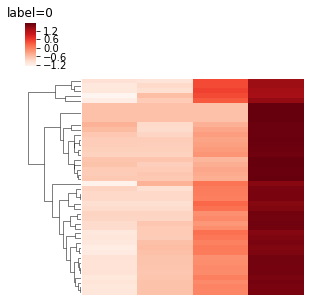

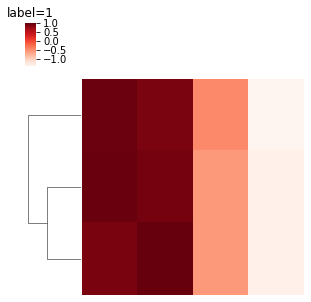

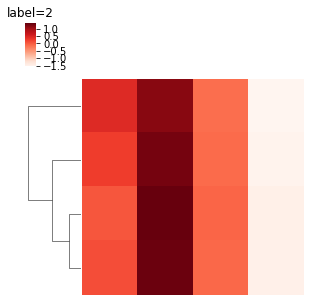

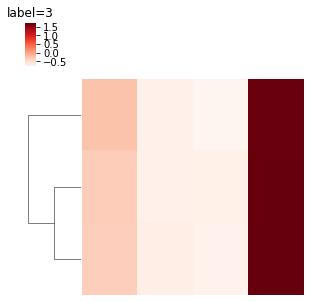

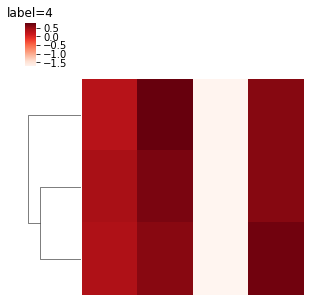

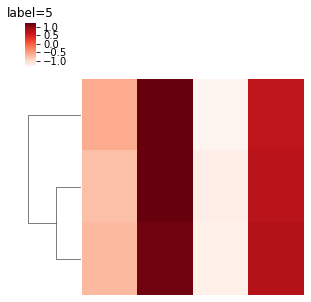

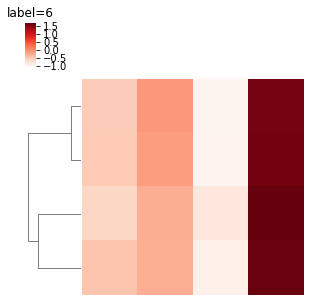

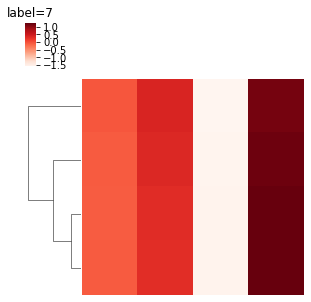

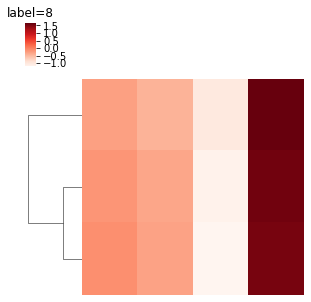

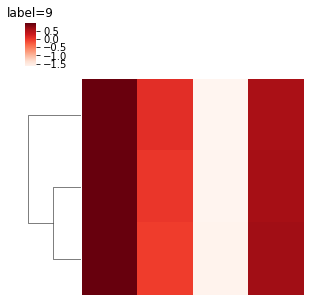

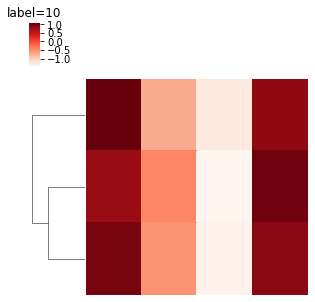

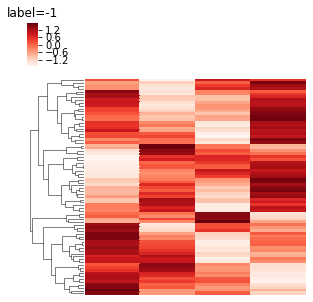

In [138]:
#Automated workflow -- pre filter
#model = cluster.OPTICS().fit(d_norm)
model = cluster.DBSCAN(eps=0.25,min_samples=3).fit(d_norm)
labels = model.labels_
unique_labels = set(model.labels_)

for i,k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
    sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=False,yticklabels=False,xticklabels=False,figsize=(5,5))
    plt.title('label='+ str(k))
    plt.show()

In [ ]:
#Loss function?

In [139]:
#automated workflow -- post extraction
select_label=[0,1,2]
d_rst = pd.DataFrame(columns=d_norm.columns)
for label in select_label:
    result = d_norm.iloc[np.argwhere(model.labels_==label).flatten()].index
    d_rst = d_rst.append(d_norm.loc[result, d_norm.columns])
d_pri_auto = d_bs.loc[d_rst.index].copy() # d_pri_auto -- automated selected result

In [158]:
d_pri_auto.to_excel('automated_priorlist_20201104.xlsx')

In [154]:
#User defined method
#1. find highest point 2. check left and right numbers 3. linear regression & check trend--decrease/increase
r2_thres = 0.8
slope_thres = 0.05
x_series=[0,4,10,29]

r2_list=[]
slop_list=[]
pattern_index = []
for index,row in d_norm.iterrows():
    max_index = np.argmax(row)
    #Divide from the highest point
    before_max = row[:max_index+1]
    before_x = x_series[:max_index+1]
    after_max = row[max_index:]
    after_x = x_series[max_index:]
    #Check if the number enough for regression
    pattern_count = 0
    if len(before_max) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(before_x,before_max)
        if r_value**2 >= r2_thres and abs(slope) >= slope_thres:
            pattern_count += 1
            r2_list.append(r_value**2)
            slop_list.append(abs(slope))
    if len(after_max) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(after_x,after_max)
        if r_value**2 >= r2_thres and abs(slope) >= slope_thres:
            pattern_count += 1
            r2_list.append(r_value**2)
            slop_list.append(abs(slope))
    if pattern_count > 0:
        pattern_index.append(index)

d_manual = d_bs.loc[pattern_index].copy()

In [159]:
d_manual.to_excel('userdefined_priorlist_20201104.xlsx')